In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import copy

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths
from utils import prf_utils


In [3]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'alexnet_all_conv_pca'

out_alexnet = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False, return_filename=False) \
       for ss in subjects]

vox_prf_inds = np.concatenate([out_alexnet[si]['best_params'][5][:,0] for si in range(n_subjects)], axis=0)

r2_cutoff = 0.01
alexnet_r2 = np.concatenate([out_alexnet[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = alexnet_r2 > r2_cutoff

In [4]:
# pull out the pRF params

prf_pars = np.concatenate([out_alexnet[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = np.round(sigma * screen_eccen_deg, 2)
angle_fwrf = np.round(angle_fwrf,2)
eccen_fwrf = np.round(eccen_fwrf,2)

x_fwrf, y_fwrf = x*screen_eccen_deg, y*screen_eccen_deg

#### Make ROIs

In [20]:
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

#### Load the S.F. selectivity values

In [22]:
fitting_type = 'gabor_solo_ridge_12ori_8sf'
out_gabor = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]

# Get info about the Gabor feature space
from feature_extraction import gabor_feature_extractor
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)
sf_unique

# Organize the feature sensitivity matrices
# feature sensitivity = corr coef between model resp and feature channel activation
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
assert(not(np.any(is_constant)))


In [23]:
np.unique(preferred_sf_corr, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32),
 array([30970, 14930, 22650, 19750, 15655,  9569,  8581, 28737]))

In [24]:
np.unique(eccen_fwrf, return_counts=True)

(array([0.  , 0.24, 0.54, 0.93, 1.43, 2.07, 2.88, 3.93, 5.28, 7.  ],
       dtype=float32),
 array([ 1136,  5944, 12215, 20165, 25501, 25992, 21525, 16502, 11394,
        10468]))

In [25]:
np.unique(size_fwrf, return_counts=True)

(array([0.17, 0.26, 0.4 , 0.62, 0.96, 1.48, 2.28, 3.52, 5.44, 8.4 ],
       dtype=float32),
 array([12197,  8321,  9122, 11345, 17248, 26391, 28893, 17797,  8187,
        11341]))

#### Group voxels across multiple ROIs

V1-hV4: rho=-0.32, p=0.00000
place: rho=-0.10, p=0.00000
face: rho=-0.04, p=0.00052


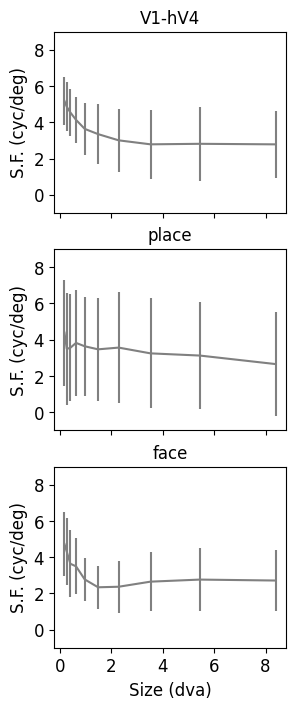

In [44]:
from utils import numpy_utils
plt.rcParams['pdf.fonttype']=42

roi_groups = [[0,1,2,3],[6,7,8],[9,10]]
roi_group_names = ['V1-hV4','place','face']
n_roi_groups = len(roi_groups)

# plt.figure(figsize=(8,2))
plt.figure(figsize=(3,8))
for rr in range(n_roi_groups):
    
    inds = np.any(np.array([roi_def.get_indices(ri) \
                                 for ri in roi_groups[rr]]), axis=0) \
                                    & abv_thresh
 
    xvals = size_fwrf[inds]
    yvals = preferred_sf_corr[inds]
    rho, p = scipy.stats.pearsonr(xvals, yvals)
    print('%s: rho=%.2f, p=%.5f'%(roi_group_names[rr], rho, p))
    
    
    plt.subplot(3,1,rr+1)
    # plt.plot(xvals, yvals, '.',color=[0.8, 0.8, 0.8])
    
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(xvals, yvals, n_bins=10,\
                                  return_std=True, use_unique=True, linear_bins=False)
    plt.errorbar(xbinned, ybinned, ystd, color=[0.5, 0.5, 0.5, 1])
    plt.title(roi_group_names[rr])
    
    if rr==2:
        plt.xlabel('Size (dva)')
        plt.xticks([0,2,4,6,8])
    else:
        plt.xticks([0,2,4,6,8],[])
    plt.ylabel('S.F. (cyc/deg)')
        
    plt.ylim([-1,9])
      
    plt.yticks([0,2,4,6,8])
    
fn2save = os.path.join(default_paths.fig_path, 'sf_vs_size_bigroigroups.pdf')
plt.savefig(fn2save, format='pdf')

V1-hV4: rho=0.52, p=0.00000
place: rho=0.44, p=0.00000
face: rho=0.44, p=0.00000


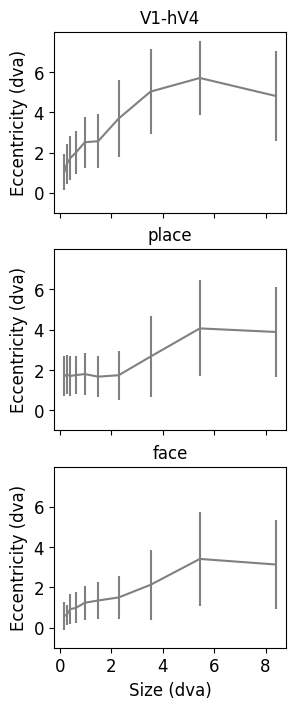

In [43]:
from utils import numpy_utils
import scipy

plt.rcParams['pdf.fonttype']=42

roi_groups = [[0,1,2,3],[6,7,8],[9,10]]
roi_group_names = ['V1-hV4','place','face']
n_roi_groups = len(roi_groups)

plt.figure(figsize=(3,8))
# plt.figure(figsize=(8,2))

for rr in range(n_roi_groups):
    
    inds = np.any(np.array([roi_def.get_indices(ri) \
                                 for ri in roi_groups[rr]]), axis=0) \
                                    & abv_thresh
 
    xvals = size_fwrf[inds]
    yvals = eccen_fwrf[inds]
    rho, p = scipy.stats.pearsonr(xvals, yvals)
    print('%s: rho=%.2f, p=%.5f'%(roi_group_names[rr], rho, p))
          
    plt.subplot(3,1,rr+1)
    # plt.plot(xvals, yvals, '.',color=[0.8, 0.8, 0.8])
    
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(xvals, yvals, n_bins=10,\
                                  return_std=True, use_unique=True, linear_bins=False)
    plt.errorbar(xbinned, ybinned, ystd, color=[0.5, 0.5, 0.5, 1])
    plt.title(roi_group_names[rr])
    
    if rr==2:
        plt.xlabel('Size (dva)')
        plt.xticks([0,2,4,6,8])
    else:
        plt.xticks([0,2,4,6,8],[])
        
    plt.ylabel('Eccentricity (dva)')
        
    plt.ylim([-1,8])
    plt.yticks([0,2,4,6])
    # plt.axis('square')
    
fn2save = os.path.join(default_paths.fig_path, 'eccen_vs_size_bigroigroups.pdf')
plt.savefig(fn2save, format='pdf')

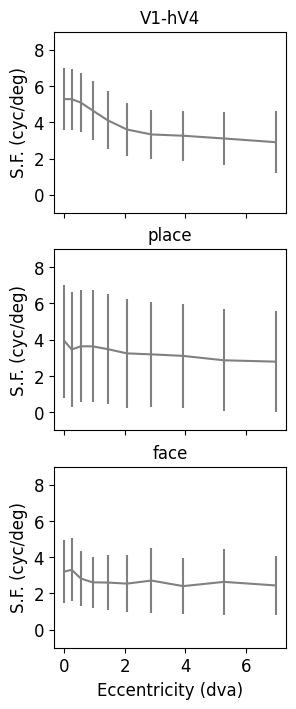

In [32]:
from utils import numpy_utils
plt.rcParams['pdf.fonttype']=42

roi_groups = [[0,1,2,3],[6,7,8],[9,10]]
roi_group_names = ['V1-hV4','place','face']
n_roi_groups = len(roi_groups)

# plt.figure(figsize=(8,2))
plt.figure(figsize=(3,8))
for rr in range(n_roi_groups):
    
    inds = np.any(np.array([roi_def.get_indices(ri) \
                                 for ri in roi_groups[rr]]), axis=0) \
                                    & abv_thresh
 
    xvals = eccen_fwrf[inds]
    yvals = preferred_sf_corr[inds]
    plt.subplot(3,1,rr+1)
    # plt.plot(xvals, yvals, '.',color=[0.8, 0.8, 0.8])
    
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(xvals, yvals, n_bins=10,\
                                  return_std=True, use_unique=True, linear_bins=False)
    plt.errorbar(xbinned, ybinned, ystd, color=[0.5, 0.5, 0.5, 1])
    plt.title(roi_group_names[rr])
    
    if rr==2:
        plt.xlabel('Eccentricity (dva)')
        plt.xticks([0,2,4,6])
    else:
        plt.xticks([0,2,4,6],[])
    plt.ylabel('S.F. (cyc/deg)')
        
    plt.ylim([-1,9])
      
    plt.yticks([0,2,4,6,8])
    
fn2save = os.path.join(default_paths.fig_path, 'sf_vs_eccen_bigroigroups.pdf')
plt.savefig(fn2save, format='pdf')

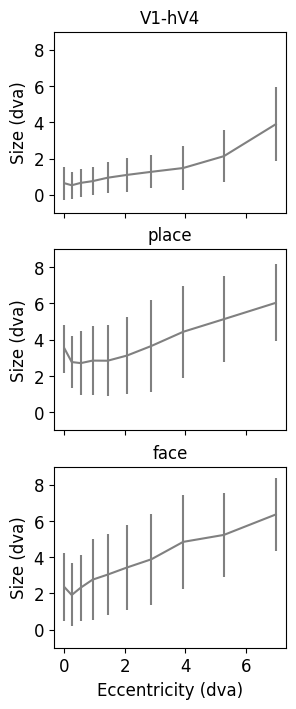

In [34]:
from utils import numpy_utils
plt.rcParams['pdf.fonttype']=42

roi_groups = [[0,1,2,3],[6,7,8],[9,10]]
roi_group_names = ['V1-hV4','place','face']
n_roi_groups = len(roi_groups)

plt.figure(figsize=(3,8))
# plt.figure(figsize=(8,2))

for rr in range(n_roi_groups):
    
    inds = np.any(np.array([roi_def.get_indices(ri) \
                                 for ri in roi_groups[rr]]), axis=0) \
                                    & abv_thresh
 
    xvals = eccen_fwrf[inds]
    yvals = size_fwrf[inds]
    plt.subplot(3,1,rr+1)
    # plt.plot(xvals, yvals, '.',color=[0.8, 0.8, 0.8])
    
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(xvals, yvals, n_bins=10,\
                                  return_std=True, use_unique=True, linear_bins=False)
    plt.errorbar(xbinned, ybinned, ystd, color=[0.5, 0.5, 0.5, 1])
    plt.title(roi_group_names[rr])
    
    if rr==2:
        plt.xlabel('Eccentricity (dva)')
        plt.xticks([0,2,4,6])
    else:
        plt.xticks([0,2,4,6],[])
        
    plt.ylabel('Size (dva)')
        
    plt.ylim([-1,9])
    plt.xticks([0,2,4,6])
    plt.yticks([0,2,4,6,8])
    # plt.axis('square')
    
fn2save = os.path.join(default_paths.fig_path, 'size_vs_eccen_bigroigroups.pdf')
plt.savefig(fn2save, format='pdf')

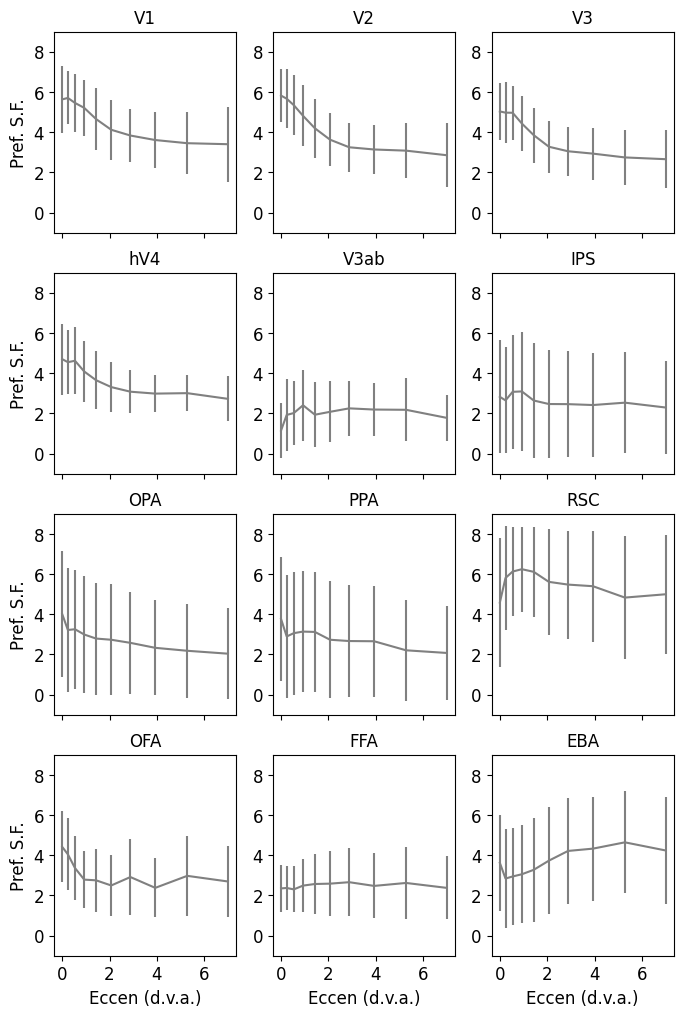

In [76]:
from utils import numpy_utils

plt.figure(figsize=(8,12))
for rr in range(n_rois):
    
    inds = roi_def.get_indices(rr) & abv_thresh
 
    xvals = eccen_fwrf[inds]
    yvals = preferred_sf_corr[inds]
    plt.subplot(4,3,rr+1)
    # plt.plot(xvals, yvals, '.')
    
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(xvals, yvals, n_bins=10,\
                                  return_std=True, use_unique=True, linear_bins=False)
    plt.errorbar(xbinned, ybinned, ystd, color=[0.5, 0.5, 0.5, 1])
    plt.title(roi_names[rr])
    
    if rr>8:
        plt.xlabel('Eccen (d.v.a.)')
        plt.xticks([0,2,4,6])
    else:
        plt.xticks([0,2,4,6],[])
    if np.mod(rr,3)==0:
        plt.ylabel('Pref. S.F.')
        
    plt.ylim([-1,9])
   
    plt.yticks([0,2,4,6,8])

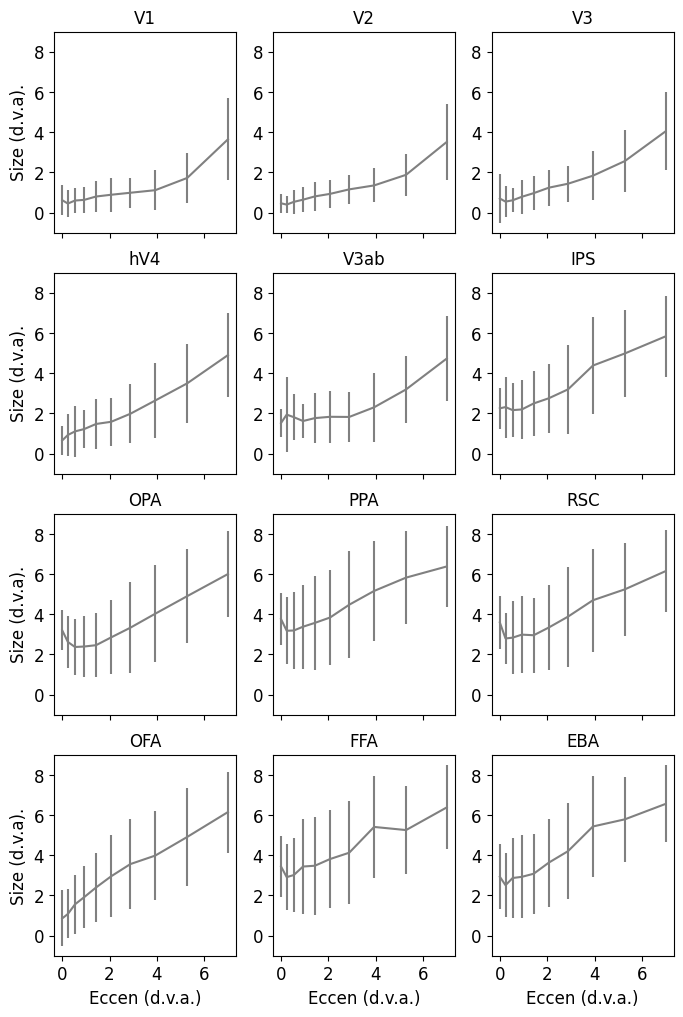

In [77]:
from utils import numpy_utils

plt.figure(figsize=(8,12))
for rr in range(n_rois):
    
    inds = roi_def.get_indices(rr) & abv_thresh
 
    xvals = eccen_fwrf[inds]
    yvals = size_fwrf[inds]
    plt.subplot(4,3,rr+1)
    # plt.plot(xvals, yvals, '.')
    
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(xvals, yvals, n_bins=10,\
                                  return_std=True, use_unique=True, linear_bins=False)
    plt.errorbar(xbinned, ybinned, ystd, color=[0.5, 0.5, 0.5, 1])
    plt.title(roi_names[rr])
    
    if rr>8:
        plt.xlabel('Eccen (d.v.a.)')
        plt.xticks([0,2,4,6])
    else:
        plt.xticks([0,2,4,6],[])
    if np.mod(rr,3)==0:
        plt.ylabel('Size (d.v.a).')
        
    plt.ylim([-1,9])
   
    plt.yticks([0,2,4,6,8])